---
title: "Gradient descent for linear regression"
format: html
---

In [2]:
using DataFrames
import CSV
using CairoMakie
using Statistics
CairoMakie.activate!(; px_per_unit = 2)

In [18]:
# Load the data
ls = DataFrame(CSV.File("../data/gradientdescent/ls.csv"))
select!(ls, Not(:P))
select!(ls, Not(:H))
ls = ls[ls.L .> 0, :]
describe(ls)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,id,3173.18,12,4318.5,5013,0,Int64
2,S,20.5667,2,12.0,1500,0,Int64
3,L,92.9935,1,13.0,51496,0,Int64


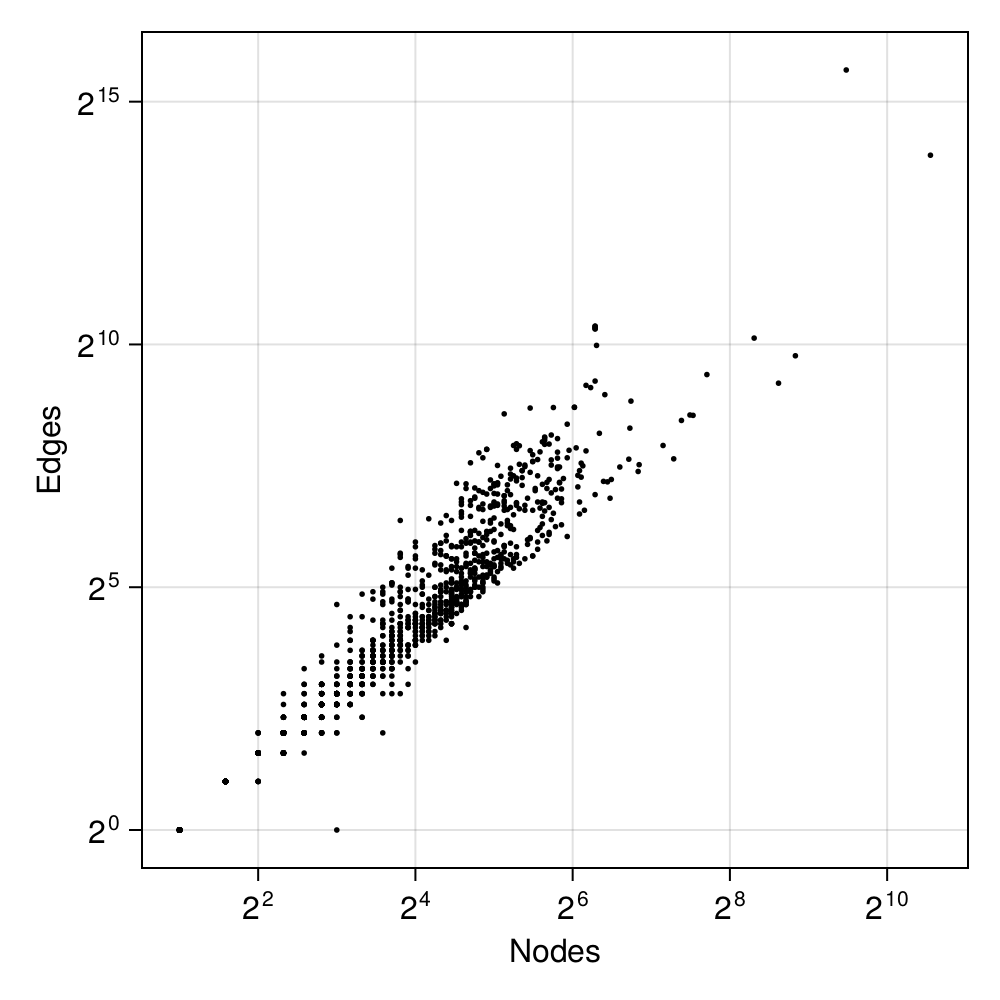

In [19]:
#| label: fig-gradient-data
#| fig-cap: >
#|  Overview of data from ...
fig = Figure(; resolution=(500, 500))
axs = Axis(fig[1,1]; xlabel="Nodes", ylabel="Edges", xscale=log2, yscale=log2)
scatter!(axs, ls.S, ls.L, color=:black, markersize=4)
current_figure()

In [20]:
# Split between training and testing
training_inclusion = rand(size(ls, 1)) .< 0.8
training = ls[findall(training_inclusion),:]
testing = ls[findall(.!training_inclusion),:]

Row,id,S,L
,Int64,Int64,Int64
1,909,142,242
2,27,114,167
3,1253,42,179
4,1217,50,261
5,1256,44,225
6,1248,52,247
7,1260,53,281
8,1247,41,137
9,1230,19,28


In [21]:
# Lin Reg machinery
using Zygote
lm(x, m, b) = m .* x .+ b
L2(ŷ, x, f, p...) = sum((ŷ .- f(x, p...)) .^ 2.0) / length(x)
∇L(ŷ, x, f, p...) = gradient((p...) -> L2(ŷ, x, f, p...), p...)
η = 1e-3

0.001

In [49]:
p = rand(2)
y = log2.(training.L)
x = log2.(training.S)
L2(y, x, lm, p...)
@info "Initial L2 loss $(L2(y, x, lm, p...))"

┌ Info: Initial L2 loss 10.549293704154634
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/gradientdescent.ipynb:5


In [50]:

epochs = 10000
for i in 1:epochs
    p .-= (η .* ∇L(y, x, lm, p...))
end
@info "Final L2 loss $(L2(y, x, lm, p...))"

┌ Info: Final L2 loss 0.3321807855171991
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/gradientdescent.ipynb:6


In [25]:
p

2-element Vector{Float64}:
  1.4459115517421541
 -1.3221244722131393

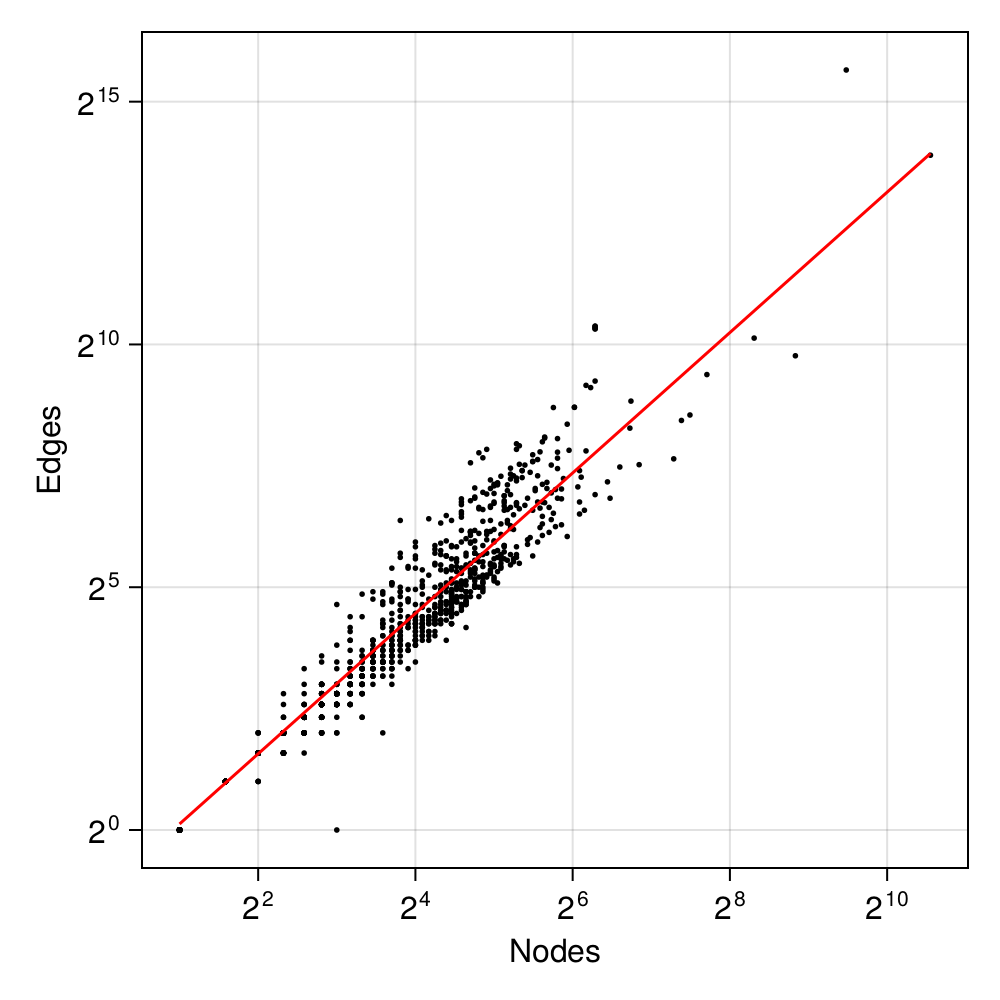

In [48]:
#| label: fig-gradient-fitted
#| fig-cap: >
#|  Overview of data from ...
fig = Figure(; resolution=(500, 500))
axs = Axis(fig[1,1]; xlabel="Nodes", ylabel="Edges", xscale=log2, yscale=log2)
scatter!(axs, training.S, training.L, color=:black, markersize=4)
pseudox = 2.0.^LinRange(1, log2.(maximum(training.S)), 20)
lines!(axs, pseudox, 2.0.^(p[1] .* log2.(pseudox) .+ p[2]), color=:red)
current_figure()

In [52]:
ty = log2.(testing.L)
tx = log2.(testing.S)
@info "Final L2 test loss $(L2(ty, tx, lm, p...))"

┌ Info: Final L2 test loss 0.38216003595941395
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/gradientdescent.ipynb:3


In [66]:
p = rand(2)
loss_train = zeros(Float64, 20_000+1)
loss_test = copy(loss_train)
loss_train[1] = L2(y, x, lm, p...)
loss_test[1] = L2(ty, tx, lm, p...)
epochs = length(loss_train)-1
for i in 1:epochs
    p .-= (η .* ∇L(y, x, lm, p...))
    loss_train[i+1] = L2(y, x, lm, p...)
    loss_test[i+1] = L2(ty, tx, lm, p...)
end

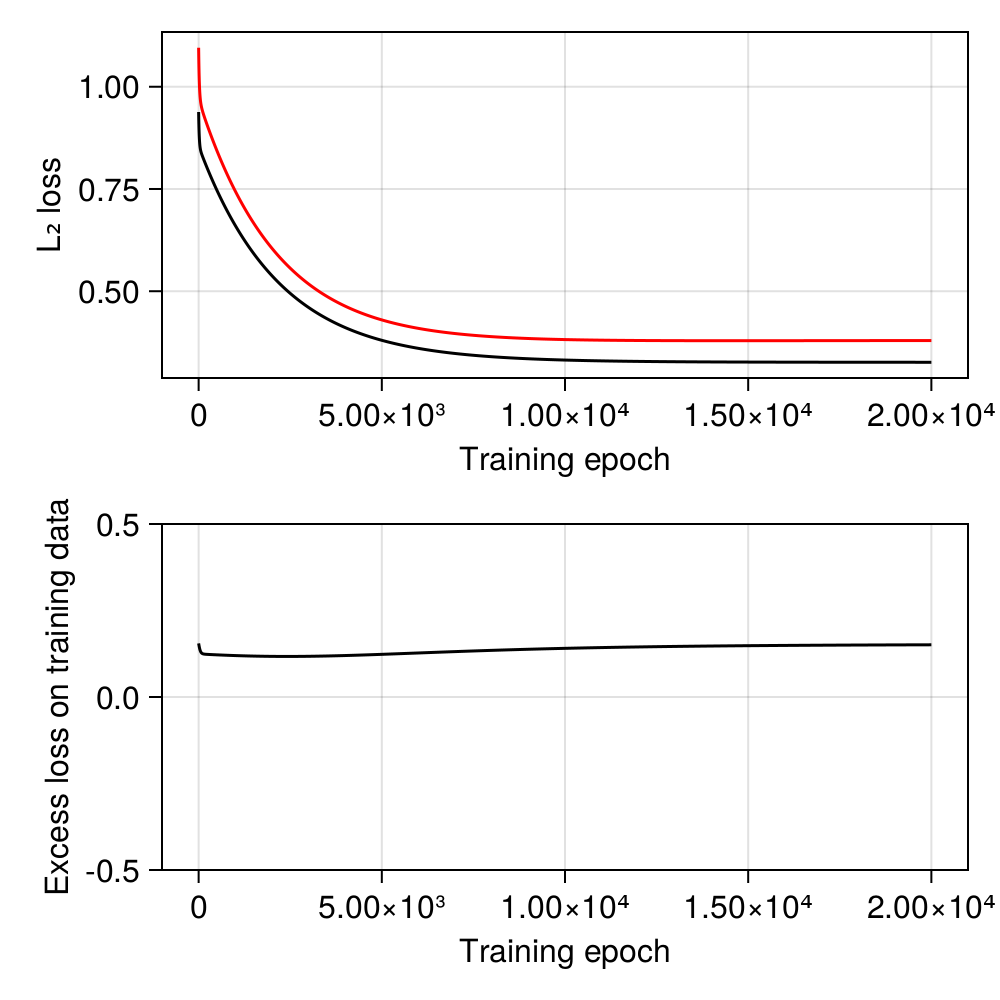

In [67]:
#| label: fig-gradient-loss-comparison
#| fig-cap: >
#|  Overview of data from ...
fig = Figure(; resolution=(500, 500))

axs = Axis(fig[1,1]; xlabel="Training epoch", ylabel="L₂ loss")
lines!(axs, 0:epochs, loss_train, color=:black)
lines!(axs, 0:epochs, loss_test, color=:red)

axs2 = Axis(fig[2,1]; xlabel="Training epoch", ylabel="Excess loss on training data")
fitdiag = loss_test ./ (loss_test .+ loss_train)
lines!(axs2, 0:epochs, log.(fitdiag ./ (1.0 .- fitdiag)), color=:black)
ylims!(axs2, (-0.5, 0.5))

current_figure()

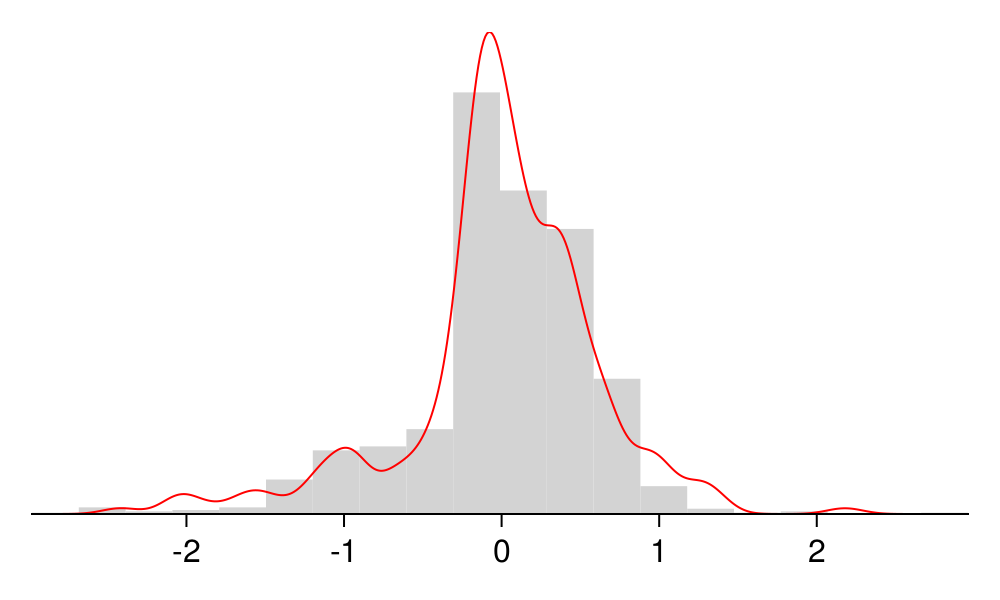

In [111]:
#| label: fig-gradient-residuals
#| fig-cap: >
#|  Overview of the distributions of residuals (note that the residuals are calculated on the $log_2(L)$ and $log_2(S)$) after a large enough
#|  number of epochs for gradient descent.
#|  The grey histogram is the residuals on the training data, and the red density line is the residuals on the testing data.
fig = Figure(; resolution=(500, 300))
axs = Axis(fig[1,1])
hist!(axs, lm(x, p...) .- y; normalization=:pdf, color=:lightgrey, bins=20)
density!(axs, lm(tx, p...) .- ty, color=:transparent, strokewidth=1, strokecolor=:red, npoints=500)
tightlimits!(axs)
hidespines!(axs, :l, :r, :t)
hideydecorations!(axs; grid=true)
hidexdecorations!(axs; grid=true, label=false, ticks=false, ticklabels=false)
current_figure()